In [1]:
import itertools
import numpy as np

import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [42]:
class CustomLogisticRegression():
        
    def __init__( self, learning_rate = 0.005, max_iter = 100 ):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.thresholding = np.vectorize( self.thresholding )
    
    def thresholding( self, x ):
        return 1 if x >= 0.5 else 0
    
    def fit( self, X, y ):
        
        #X = X.as_matrix()
        y = y.as_matrix().ravel()
        
        # Number of features + intercept
        num_features = X.shape[ 1 ]
        # Number of instances
        num_instances = X.shape[ 0 ]
        
        # Coeficients initialization
        self.W = np.zeros( num_features )
        
        # Iterations
        for i in range( self.max_iter ):
            x_index = np.random.randint( num_instances )
            Wxi = np.dot( self.W, X[ x_index ].T )
            g = 1 / ( 1 + np.exp( -Wxi ) )
            e = y[ x_index ] - g
            self.W = self.W + self.learning_rate * e * X[ x_index ]
    
    def predict( self, X ):
        #X = X.as_matrix()
        WX = np.dot( self.W, X.T )
        g = 1 / ( 1 + np.exp( -WX ) )
        return self.thresholding( g.ravel() )

# Loading dataset

In [2]:
# https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_df = pd.read_csv( './data/HTRU_2.csv', names = [ 'Mean of the integrated profile', 
                                                     'Standard deviation of the integrated profile', 
                                                     'Excess kurtosis of the integrated profile', 
                                                     'Skewness of the integrated profile', 
                                                     'Mean of the DM-SNR curve', 
                                                     'Standard deviation of the DM-SNR curve', 
                                                     'Excess kurtosis of the DM-SNR curve', 
                                                     'Skewness of the DM-SNR curve',
                                                    'Class' ] )

In [3]:
htru_df.dtypes

Mean of the integrated profile                  float64
Standard deviation of the integrated profile    float64
Excess kurtosis of the integrated profile       float64
Skewness of the integrated profile              float64
Mean of the DM-SNR curve                        float64
Standard deviation of the DM-SNR curve          float64
Excess kurtosis of the DM-SNR curve             float64
Skewness of the DM-SNR curve                    float64
Class                                             int64
dtype: object

In [4]:
htru_df.shape

(17898, 9)

In [5]:
htru_df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [6]:
#pandas_profiling.ProfileReport( htru_df )

# Splitting dataset

In [12]:
htru_df[ 'Class' ].value_counts()

0    16259
1     1639
Name: Class, dtype: int64

In [13]:
# Se realiza particionamiento de las clases para asegurar que se mantenga la misma proporción en ambos datasets
htru_pos_df = htru_df.loc[ htru_df[ 'Class' ] == 1 ]
htru_neg_df = htru_df.loc[ htru_df[ 'Class' ] == 0 ]

In [14]:
# Se parte el dataset de entrenamiento (TOTAL) del de prueba
htru_pos_train_df, htru_pos_test_df =  train_test_split( htru_pos_df, test_size = 1000, random_state = 1 )
htru_neg_train_df, htru_neg_test_df =  train_test_split( htru_neg_df, test_size = 9000, random_state = 1 )

In [15]:
htru_pos_train_df.shape

(639, 9)

In [16]:
htru_neg_train_df.shape

(7259, 9)

In [17]:
htru_pos_test_df.shape

(1000, 9)

In [18]:
htru_neg_test_df.shape

(9000, 9)

In [19]:
htru_test_df = pd.concat( [ htru_pos_test_df, htru_neg_test_df ] )

In [20]:
htru_test_df.shape

(10000, 9)

# Model Fitting

In [21]:
features = htru_df.columns[ : -1 ].tolist()
len( features )

8

In [27]:
def model_iteration( model, train_df, test_df, features, target ):
    
    # Pipeline creation
    model = Pipeline( [
        ( 'scaler', StandardScaler() ),
        ( 'model', model )
    ] )
    
    # Training the model
    model.fit( train_df[ features ], train_df[ target ] )
    
    # Generating predictions for train and test datasets
    train_preds = model.predict( train_df[ features ] )
    test_preds = model.predict( test_df[ features ] )
    
    # Getting precisions for train and test datasets
    precision_train = precision_score( train_df[ target ], train_preds )
    precision_test = precision_score( test_df[ target ], test_preds )
    
    # Getting recalls for train and test datasets
    recall_train = recall_score( train_df[ target ], train_preds )
    recall_test = recall_score( test_df[ target ], test_preds )
    
    return precision_train, precision_test, recall_train, recall_test

In [43]:
sklearn_model = LogisticRegression( random_state = 1, fit_intercept = False )
custom_model = CustomLogisticRegression()

train_instances = [ 100, 500, 1000, 5000 ]

sklearn_precisions_train = []
sklearn_precisions_test = []
sklearn_recalls_train = []
sklearn_recalls_test = []

custom_precisions_train = []
custom_precisions_test = []
custom_recalls_train = []
custom_recalls_test = []

for step in train_instances:
    
    print( 'Training with ' + str( step ) + ' training samples'  )
    
    # Creating training dataset
    htru_pos_train_step_df, _ = train_test_split( htru_pos_train_df, train_size = int( step * .1 ), random_state = 1 )
    htru_neg_train_step_df, _ = train_test_split( htru_neg_train_df, train_size = int( step * .9 ), random_state = 1 )
    htru_train_step_df = pd.concat( [ htru_pos_train_step_df, htru_neg_train_step_df ] )
    
    # Training sklearn LogReg model
    sk_precision_train, sk_precision_test, sk_recall_train, sk_recall_test = model_iteration( sklearn_model, htru_train_step_df, htru_test_df, features, 'Class' )
    sklearn_precisions_train.append( sk_precision_train )
    sklearn_precisions_test.append( sk_precision_test )
    sklearn_recalls_train.append( sk_recall_train )
    sklearn_recalls_test.append( sk_recall_test )
    
    # Training custom model
    cus_precision_train, cus_precision_test, cus_recall_train, cus_recall_test = model_iteration( custom_model, htru_train_step_df, htru_test_df, features, 'Class' )
    custom_precisions_train.append( cus_precision_train )
    custom_precisions_test.append( cus_precision_test )
    custom_recalls_train.append( cus_recall_train )
    custom_recalls_test.append( cus_recall_test )

Training with 100 training samples
Training with 500 training samples
Training with 1000 training samples


C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\fc.pena\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\fc.pena\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\fc.pena\Anaconda3\lib\site-packages\ipyk

Training with 5000 training samples


C:\Users\fc.pena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\fc.pena\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0.5,1,'Custom')

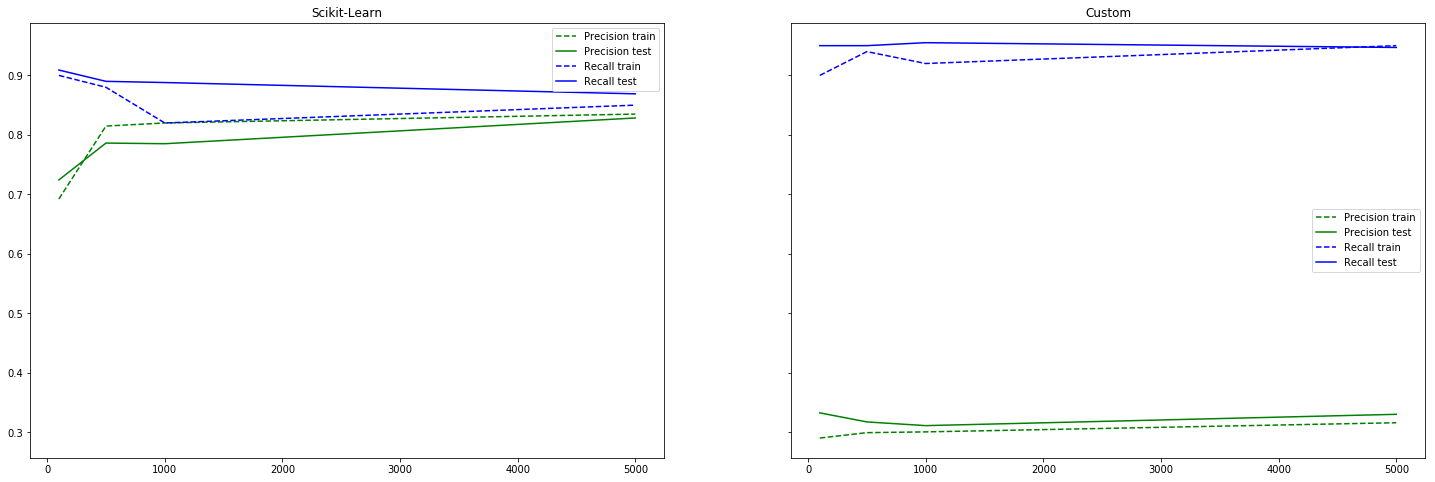

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = ( 25, 8 ) )

ax1.plot( train_instances, sklearn_precisions_train, '--g', label = 'Precision train' )
ax1.plot( train_instances, sklearn_precisions_test, '-g', label = 'Precision test' )
ax1.plot( train_instances, sklearn_recalls_train, '--b', label = 'Recall train' )
ax1.plot( train_instances, sklearn_recalls_test, '-b', label = 'Recall test' )
ax1.legend()
ax1.set_title( 'Scikit-Learn' )

ax2.plot( train_instances, custom_precisions_train, '--g', label = 'Precision train' )
ax2.plot( train_instances, custom_precisions_test, '-g', label = 'Precision test' )
ax2.plot( train_instances, custom_recalls_train, '--b', label = 'Recall train' )
ax2.plot( train_instances, custom_recalls_test, '-b', label = 'Recall test' )
ax2.legend()
ax2.set_title( 'Custom' )

In [ ]:
4/0.02*np.log(4/0.05)